# Time Series Forecasting 
## Using Machine Learning to Forecast Energy Consumption


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


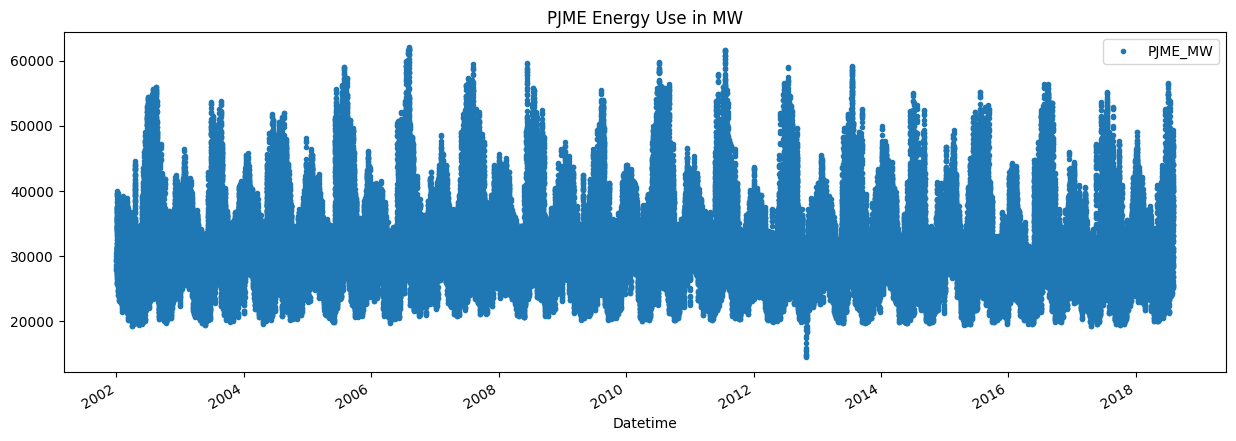

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

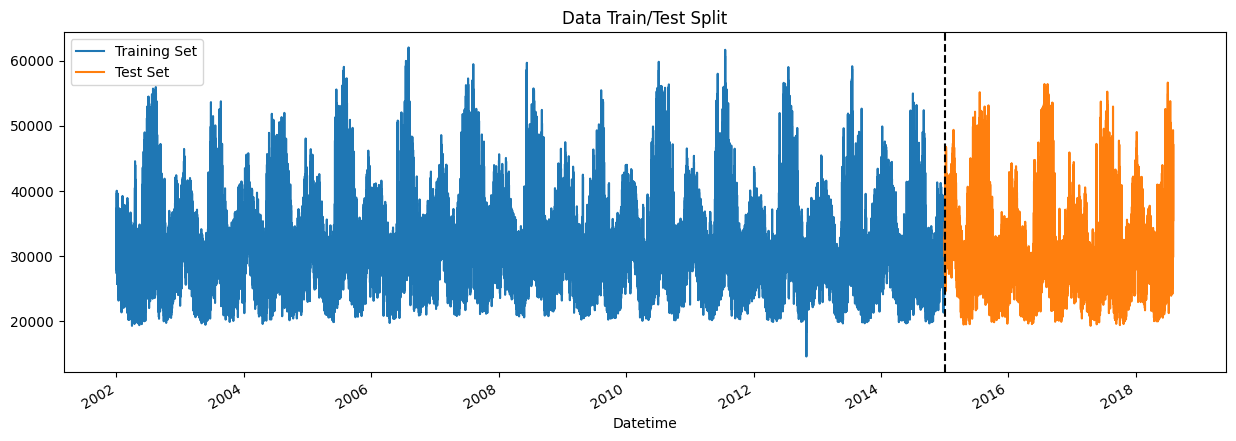

In [5]:
#Split Data 70% Train and 30% Test
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

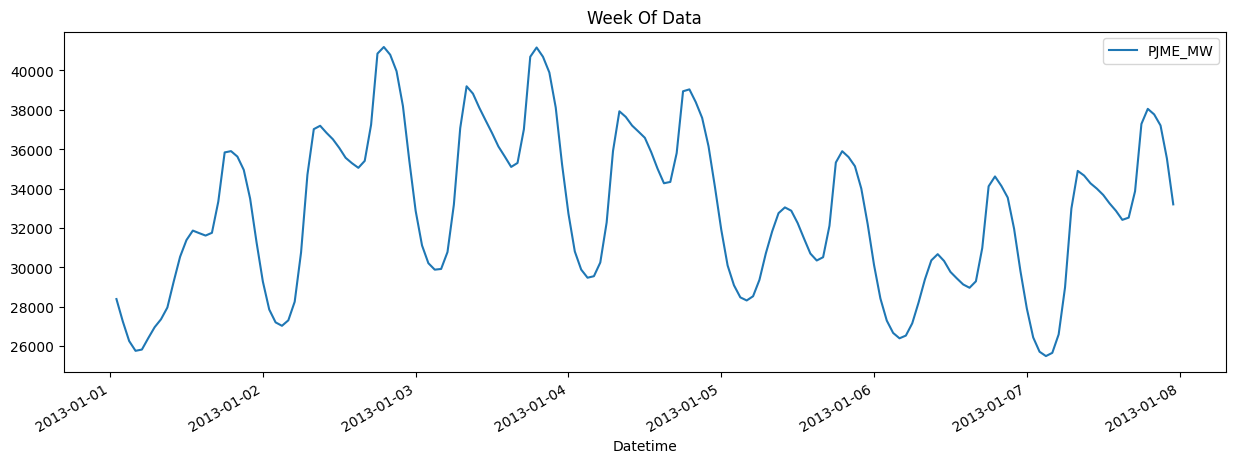

In [6]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-08-2013')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

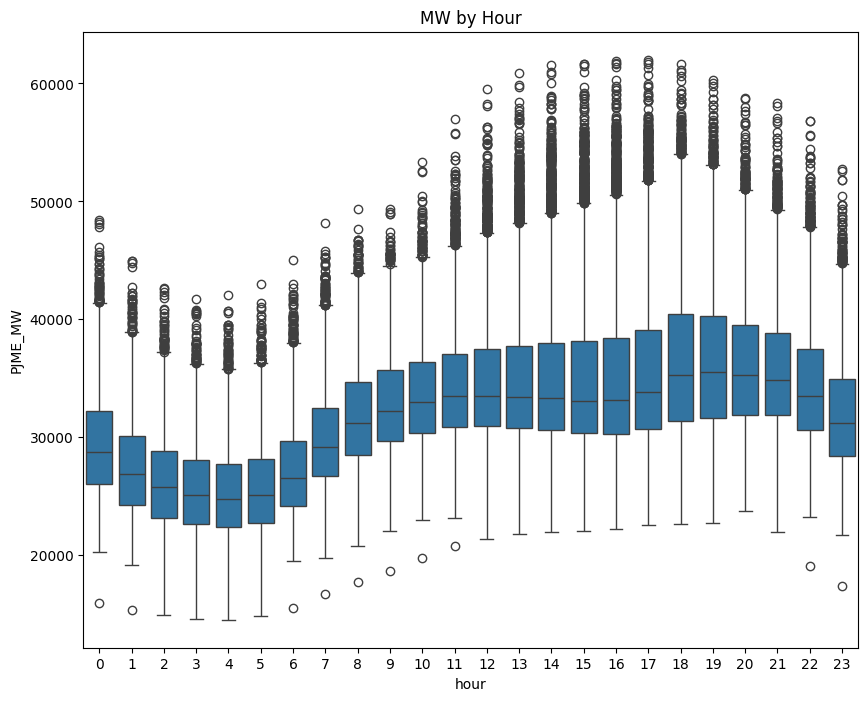

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

/var/folders/gn/11k7855j0877dctzqqz6s0q80000gq/T/ipykernel_59942/2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


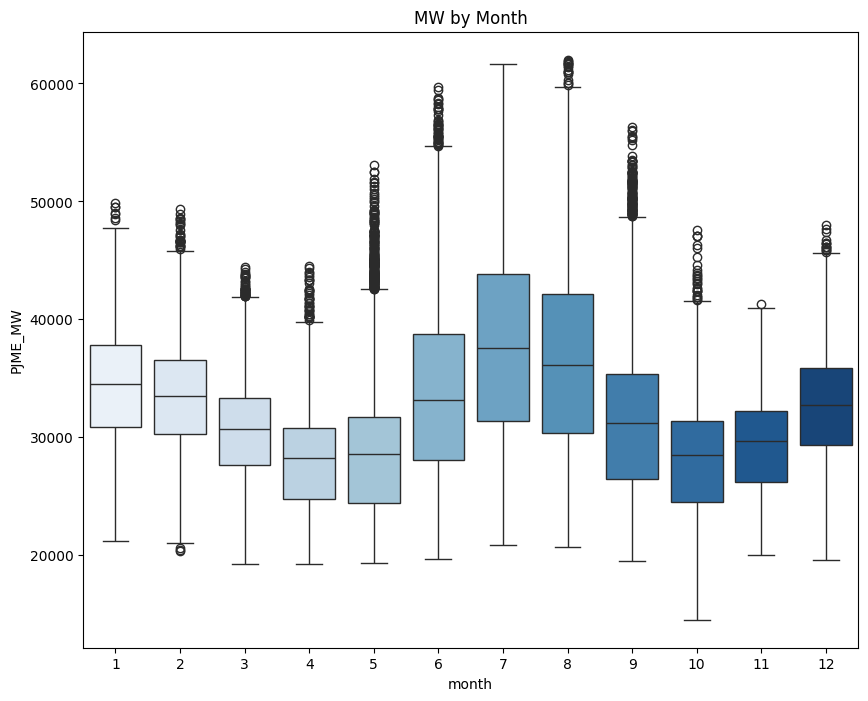

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# First Model and Testing

In [11]:
eval_result = {}
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Make predictions on the test set
y_pred = reg.predict(X_test)

In [13]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

Test MSE: 13889027.66092699


In [14]:
# Calculate Root Mean Squared Error
rmse = mse ** 0.5
print(f"Test RMSE: {rmse}")

Test RMSE: 3726.7985806757774


In [15]:
from sklearn.metrics import r2_score

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f"Test R² Score: {r2}")

Test R² Score: 0.6661183856371169


## Regularization vs Non-Regularization

I tried the model with both L1 Regularization and L2 Regularization and did not perform substantially better in testing. 

# Optimize Parameters using GridSearch and Testing

In [16]:
param_grid = {
    'n_estimators': [500, 1000],  # Reduced options
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8],
    'objective': ['reg:squarederror']
}

In [17]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(early_stopping_rounds=50)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use the appropriate scoring metric
    cv=2,  # Cross-validation folds
    verbose=1,  # Increase verbosity to see progress
    n_jobs=-1  # Use all available cores
)

# Fit the model and Grid Search
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'subsample': 0.8}
Best cross-validation score: -11566773.804516248


In [18]:
better_model = xgb.XGBRegressor(reg_alpha=0.1, base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       colsample_bytree=0.8,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01,
                       subsample=0.8)
better_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32602.39074	validation_1-rmse:31654.69998
[100]	validation_0-rmse:12472.94619	validation_1-rmse:11771.10320
[200]	validation_0-rmse:5530.15238	validation_1-rmse:5267.74799
[300]	validation_0-rmse:3527.91993	validation_1-rmse:3860.07752
[400]	validation_0-rmse:3059.22548	validation_1-rmse:3694.43496
[462]	validation_0-rmse:2958.27978	validation_1-rmse:3695.43345


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# Make predictions on the test set
y_pred2 = better_model.predict(X_test)

In [20]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred2)
print(f"Test MSE: {mse}")

Test MSE: 13632253.937801242


In [21]:
# Calculate Root Mean Squared Error
rmse = mse ** 0.5
print(f"Test RMSE: {rmse}")

Test RMSE: 3692.1882316319197


In [22]:
# Calculate R² Score
r2 = r2_score(y_test, y_pred2)
print(f"Test R² Score: {r2}")

Test R² Score: 0.6722910297772374


## Regularization vs Non-Regularization

I tried the model with both L1 Regularization and L2 Regularization and did not perform substantially better in testing. 

# Paramters RandomSearch and Testing

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'objective': ['reg:squarederror']
}

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(early_stopping_rounds=50)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    cv=2,  # Cross-validation folds
    verbose=1,  # Increase verbosity to see progress
    n_jobs=-1,
    random_state=42
)

# Fit the model and Randomized Search
random_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

# Print the best parameters and the best score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters found: {'subsample': 1.0, 'objective': 'reg:squarederror', 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best cross-validation score: -11218274.77694346


In [24]:
better_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       colsample_bytree=1.0,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.05,
                       subsample=1.0,
                        eval_metric='rmse')

#better_model.fit(X_train, y_train,
        #eval_set=[(X_train, y_train), (X_test, y_test)],
        #verbose=100)

In [25]:
eval_result = {}

# Fit the model and store evaluation results in eval_result
better_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# After fitting, you can access the evaluation results through the model’s `evals_result` attribute
eval_result = better_model.evals_result()

[0]	validation_0-rmse:31303.40550	validation_1-rmse:30355.94856
[100]	validation_0-rmse:2868.46044	validation_1-rmse:3736.24150
[126]	validation_0-rmse:2773.05669	validation_1-rmse:3787.43362


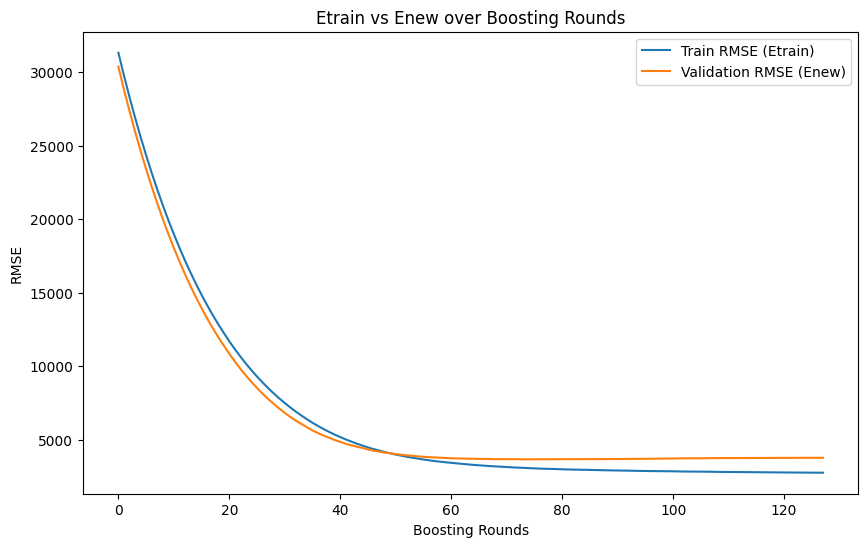

In [26]:
# Extract RMSE values from the eval_result dictionary
epochs = len(eval_result['validation_0']['rmse'])
x_axis = range(0, epochs)
train_rmse = eval_result['validation_0']['rmse']
val_rmse = eval_result['validation_1']['rmse']

# Plot Etrain vs Enew
plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_rmse, label='Train RMSE (Etrain)')
plt.plot(x_axis, val_rmse, label='Validation RMSE (Enew)')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Etrain vs Enew over Boosting Rounds')
plt.legend()
plt.show()

## What Did we Learn?

The training error decreases rapidly at first, then flattens out, indicating the model is fitting the data well without significant improvement from additional boosting rounds. The validation error follows a similar pattern, remaining close to the training error, suggesting the model is well-tuned and not overfitting.

In [27]:
# Make predictions on the test set
y_pred2 = better_model.predict(X_test)

In [28]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred2)
print(f"Test MSE: {mse}")

Test MSE: 13552055.232230743


In [29]:
# Calculate Root Mean Squared Error
rmse = mse ** 0.5
print(f"Test RMSE: {rmse}")

Test RMSE: 3681.31161846301


In [30]:
# Calculate R² Score
r2 = r2_score(y_test, y_pred2)
print(f"Test R² Score: {r2}")

Test R² Score: 0.6742189453908711


# Performance 
## Optimized Random Search parameter Performed better than the Grid Search parameters
We will move forward with the latest parameter changes model

# Feature Importance

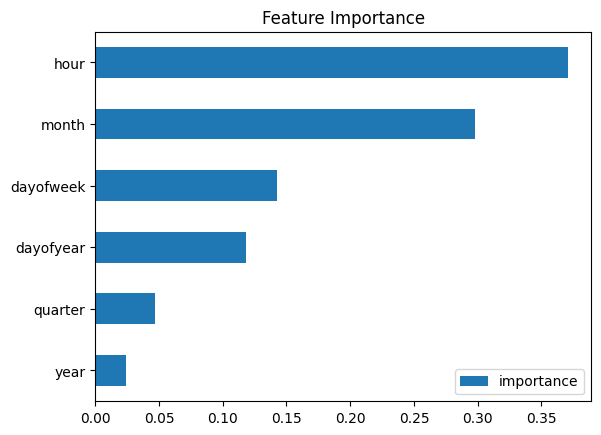

In [31]:
fi = pd.DataFrame(data=better_model.feature_importances_,
             index=better_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

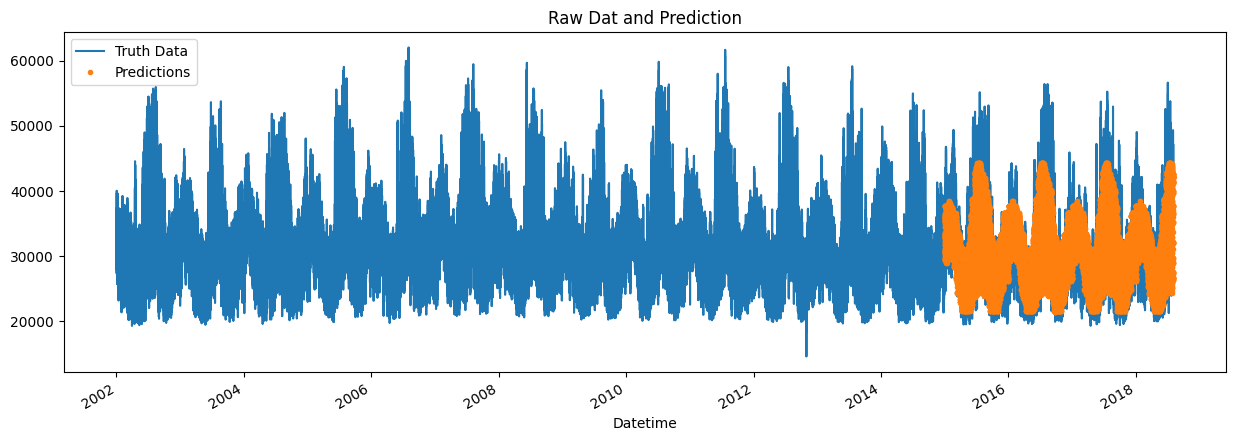

In [32]:
test['prediction'] = better_model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

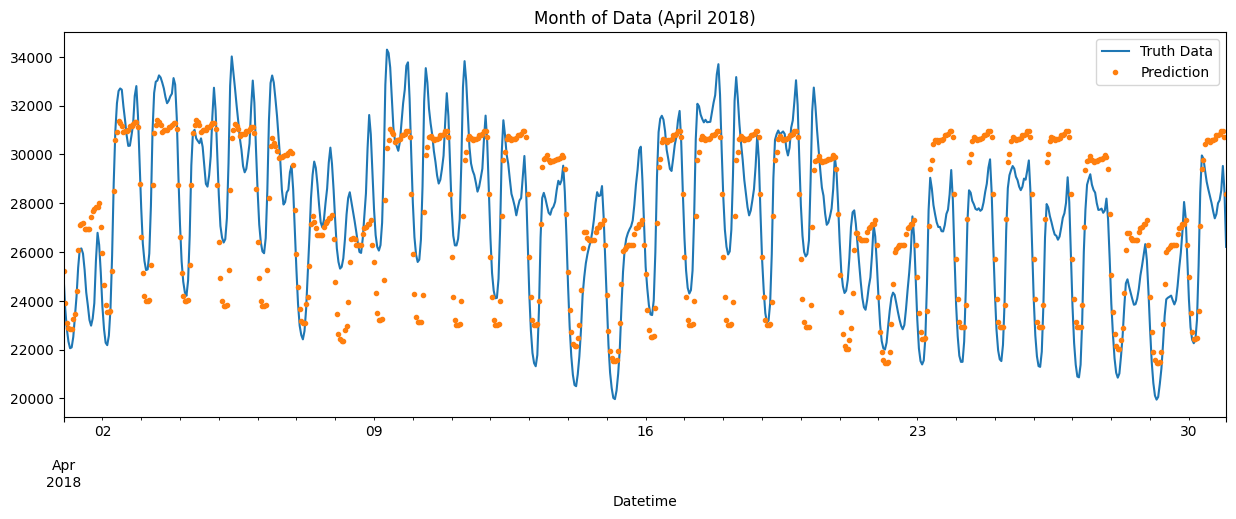

In [33]:
# Define the month you want to visualize
start_date = '04-01-2018'
end_date = '05-01-2018'  # End date is the first day of the next month

# Plot the actual values ('PJME_MW') and predicted values ('prediction') for the specified month
ax = df.loc[(df.index >= start_date) & (df.index < end_date)]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Month of Data (April 2018)')
df.loc[(df.index >= start_date) & (df.index < end_date)]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

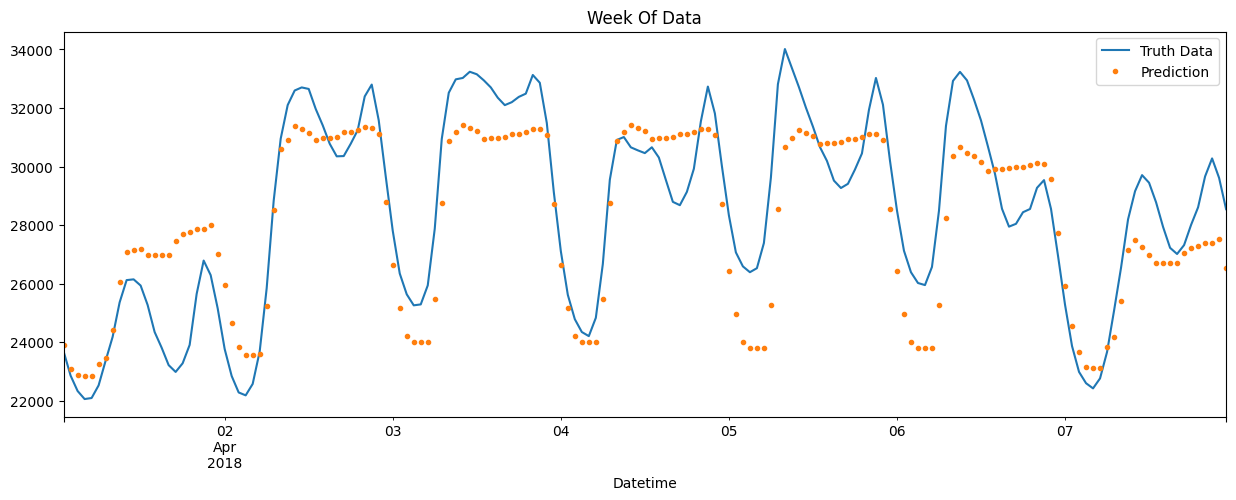

In [34]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

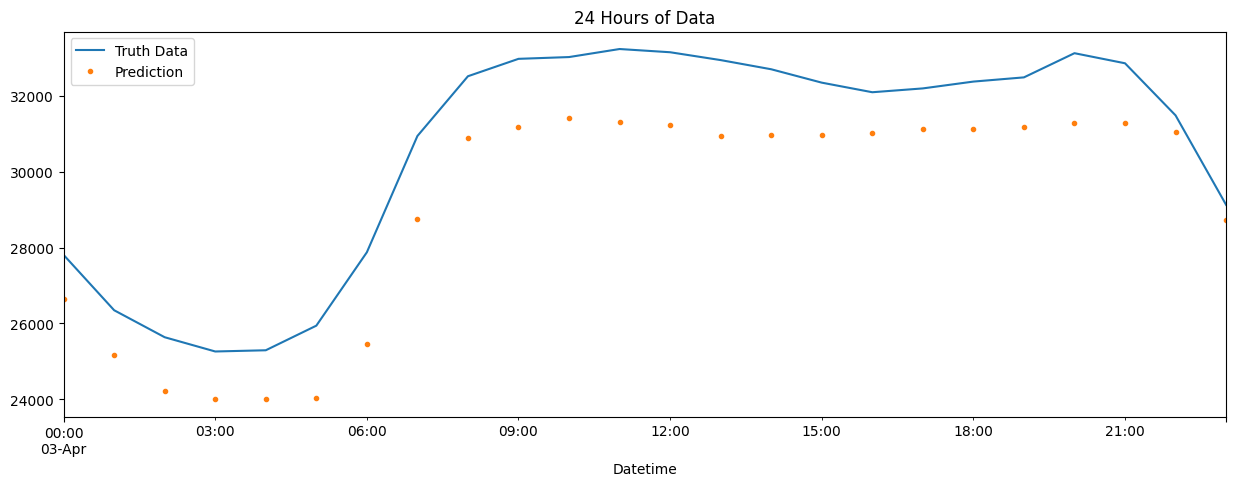

In [35]:
# Define the 24-hour period you want to visualize
start_date = '04-03-2018'
end_date = '04-04-2018'

# Plot the actual values ('PJME_MW') and predicted values ('prediction') for the specified 24-hour period
ax = df.loc[(df.index >= start_date) & (df.index < end_date)]['PJME_MW'] \
    .plot(figsize=(15, 5), title='24 Hours of Data')
df.loc[(df.index >= start_date) & (df.index < end_date)]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

# Predictions

We can See that for Years, Month, Week, and a Day our historical prediction model fits the data well.

This project aimed to develop a robust machine learning model capable of forecasting a time series energy consumption with the goal of improving energy management and contributing to decision-making processes in the energy sector, particularly in the context of energy trading.

The model can directly support energy trading strategies by enabling more accurate demand forecasting, which can be leveraged to anticipate price movements. This can inform buying and selling decisions, optimize contract pricing, and reduce trading risks through more precise demand management

# Next Steps

Work on including a model with pricing. This could involve forecasting price fluctuations or making more informed buy/sell decisions based on predicted demand. This is now a project I am currently working on.

# The End